<a href="https://colab.research.google.com/github/ferrogh/bangkit-assignments/blob/branch_miftah/%5BMiftah%5D_FAKE_JOB_POSTING_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FAKE JOB POSTINGS PREDICTION**

Members:
- Ferro Geraldi Hardian
- Miftah Ahmad Choiri 
- Irfan Abdurrahman 

---
##**Programming Workflow:**
1. READING AND UNDERSTANDING THE DATA
  - Import the Important Statements
  - Load the Fake Job Datasets

2. CONSTRUCT DATASET
  - Collecting Data
  - Identify Feature and Label Sources
  - Wordcloud & Ngrams Analysis
  - Sampling and Splitting

3. TRANSFORM DATASET
  - Clean up Text, Stopwords, Stemmer, and Lemmatizer 
  - Tokenizer, Sequence, Padded


4. BUILD AND TRAIN MODEL
  - Neural Network Architecture
  - Train Model
  - Evaluate Model Accuracy

5. RESULT & CONCLUSION




---
##**1. READING AND UNDERSTANDING DATA**
  - Import the Important Statements
  - Load the Fake Job Datasets
  
  The dataset is retrieved from https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction

In [0]:
#Use the right version of TensorFlow
%tensorflow_version 2.x
#-------------------------------------------------------------------------------
#LOAD THE IMPORT
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import re
import time
import string
import os

plt.style.use('fivethirtyeight')
nltk.download('stopwords')
nltk.download('wordnet')
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score

from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional, GlobalMaxPool1D, BatchNormalization, Embedding, LSTM, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#Code to read csv file into Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#Authenticate and create the PyDrive Client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive=GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1nLzstifhaqf1csg_DOR49JdiUn_gv5Vu'
fluff, id = link.split('=')
print (id) #Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('fake_job_postings.csv')
df = pd.read_csv('fake_job_postings.csv')
df.head()


1nLzstifhaqf1csg_DOR49JdiUn_gv5Vu


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Text(0.5, 1.0, 'Target Count in Dataset')

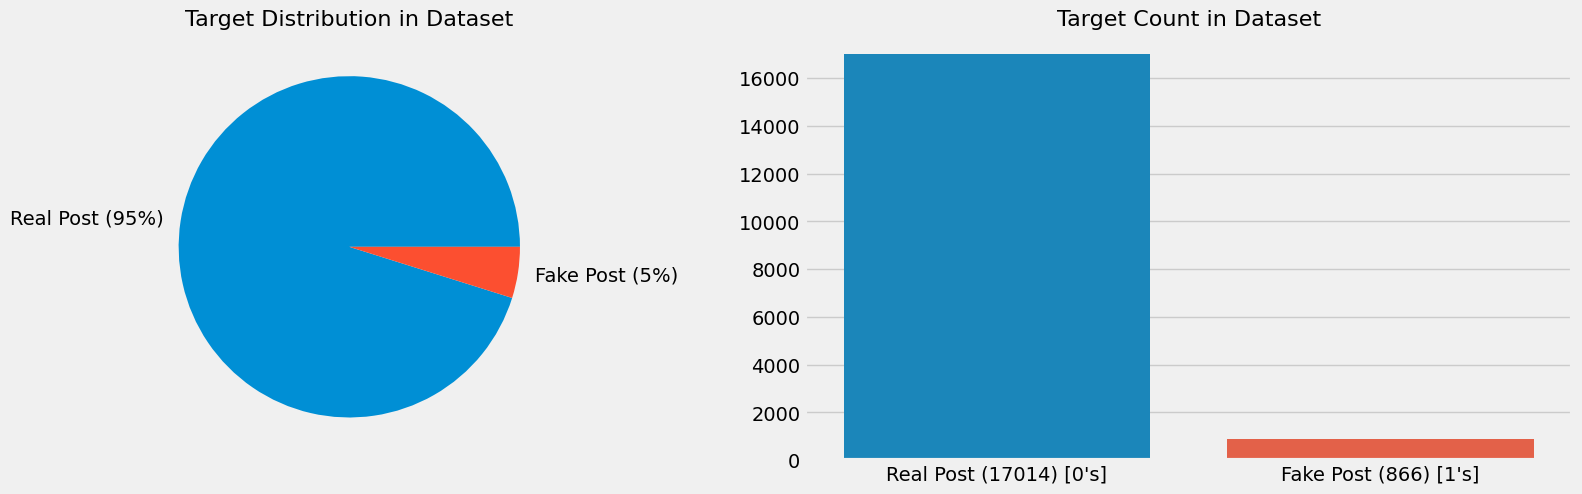

In [0]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
plt. tight_layout()

df["fraudulent"].value_counts().plot(
    kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fake Post (5%)'])
temp = df["fraudulent"].value_counts()
sns.barplot(temp.index, temp, ax=axes[1])

#Label the Axes
axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fake Post (866) [1's]"])
axes[0].set_title('Target Distribution in Dataset', fontsize=16)
axes[1].set_title('Target Count in Dataset', fontsize=16)

---
##**2. CONSTRUCT DATASET**
  - Data Exploratory & Analysis
  - Identify Feature and Label Sources
  - Wordcloud & Ngrams Analysis
  - Sampling and Splitting


###**Data Exploratory & Analysis**

In [0]:
#Check Missing Values
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [0]:
#Extracting Text Features
text_df = df[["title", "company_profile", "description", "requirements", "benefits", "fraudulent"]]
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [0]:
#Categorical Features
cat_df = df[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function", "fraudulent"]]
cat_df = cat_df.fillna("None")

cat_df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


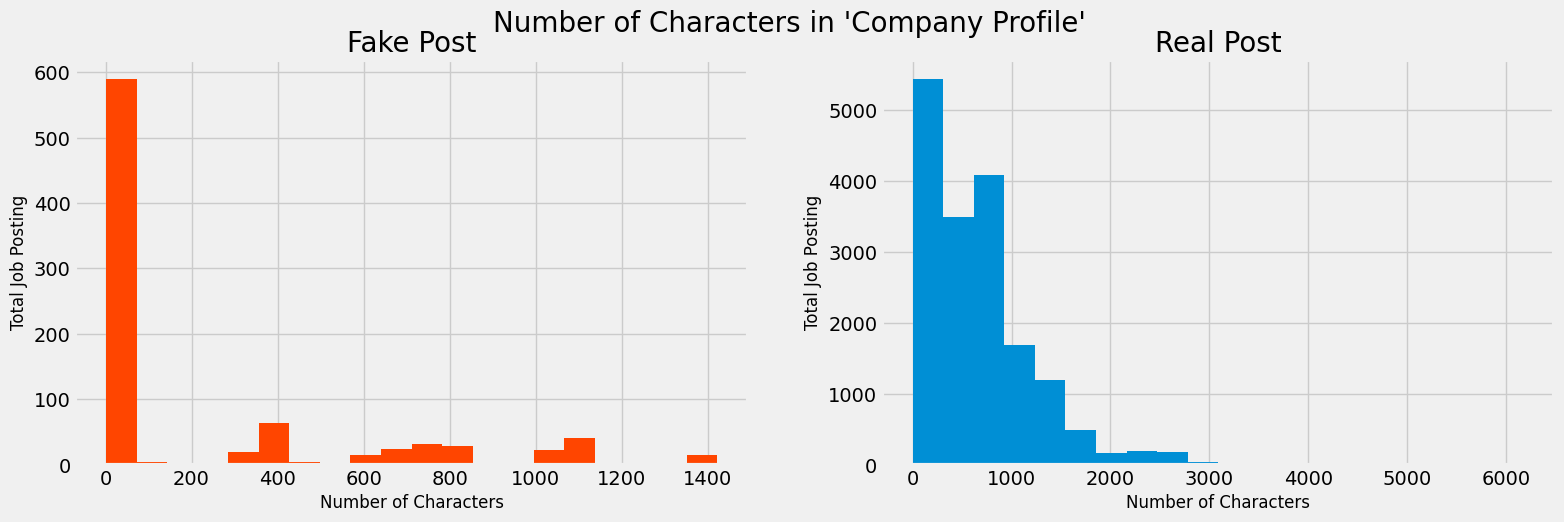

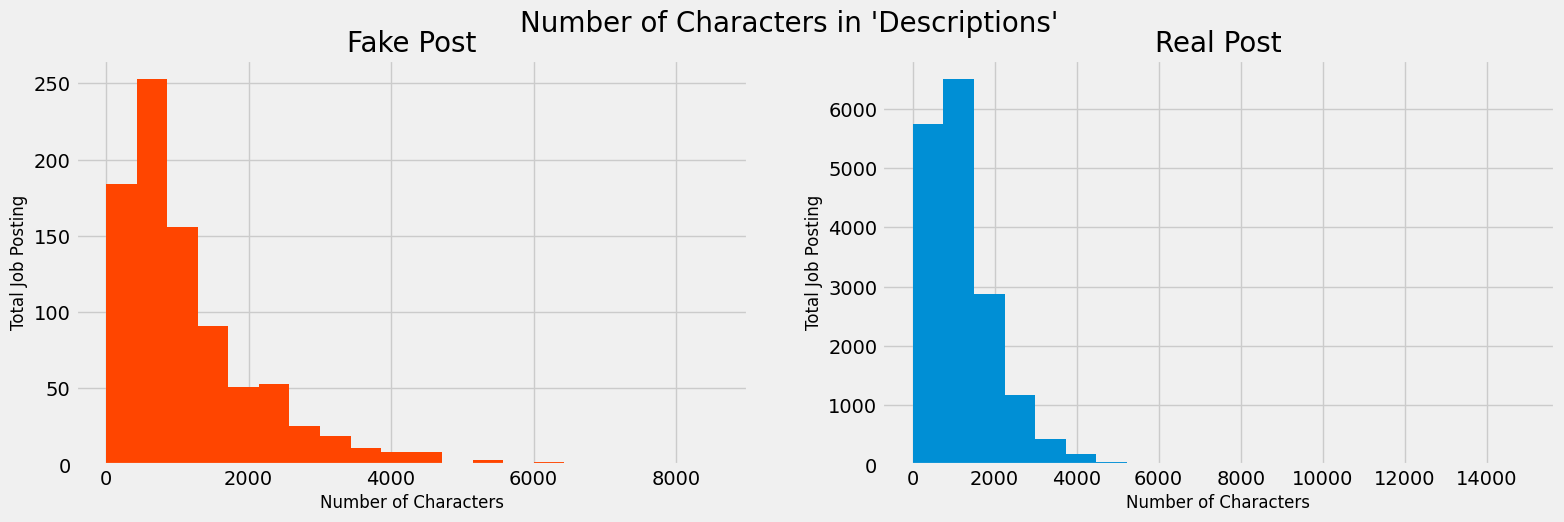

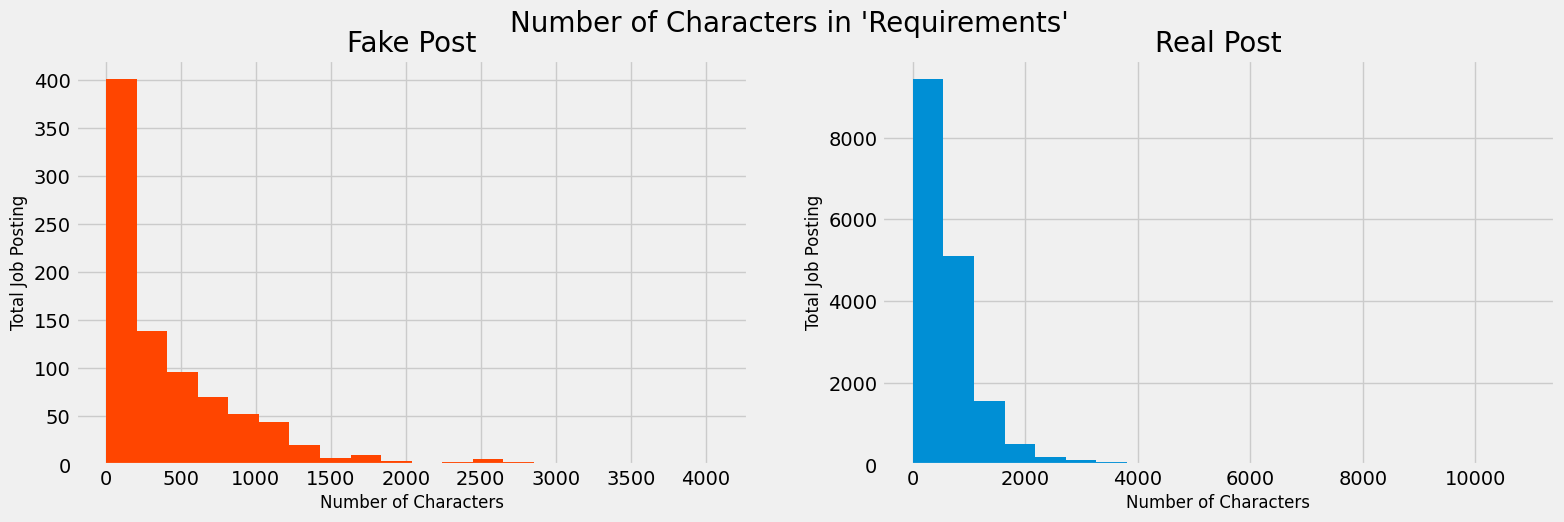

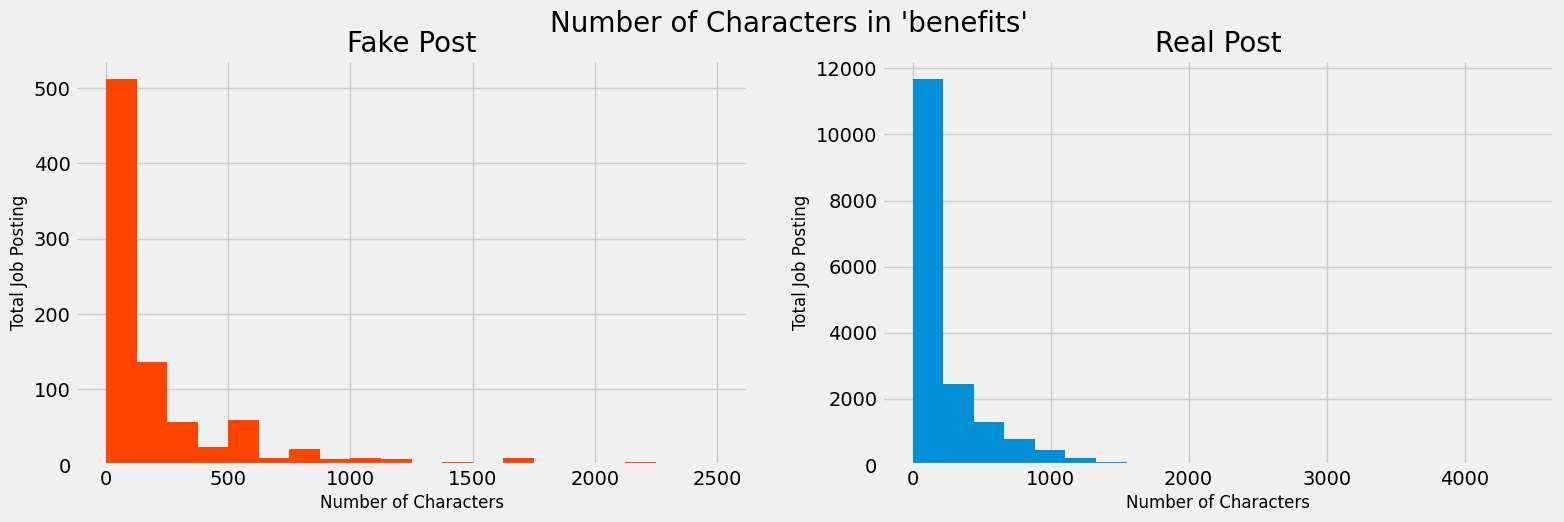

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
fig.suptitle("Number of Characters in 'Company Profile'", fontsize=20)

length = text_df[text_df["fraudulent"]==1]['company_profile'].str.len()
ax1.hist(length, bins = 20, color = 'orangered')
ax1.set_title('Fake Post', fontsize=20)
ax1.set_xlabel('Number of Characters', fontsize=12) # x axis label
ax1.set_ylabel('Total Job Posting', fontsize=12) # x axis label

length = text_df[text_df['fraudulent']==0]['company_profile'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post', fontsize=20)
ax2.set_xlabel('Number of Characters', fontsize=12) # x axis label
ax2.set_ylabel('Total Job Posting', fontsize=12) # x axis label

fig, (ax3, ax4) = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
fig.suptitle("Number of Characters in 'Descriptions'", fontsize=20)

length = text_df[text_df["fraudulent"]==1]['description'].str.len()
ax3.hist(length, bins = 20, color = 'orangered')
ax3.set_title('Fake Post', fontsize=20)
ax3.set_xlabel('Number of Characters', fontsize=12) # x axis label
ax3.set_ylabel('Total Job Posting', fontsize=12) # x axis label

length = text_df[text_df['fraudulent']==0]['description'].str.len()
ax4.hist(length, bins = 20)
ax4.set_title('Real Post', fontsize=20)
ax4.set_xlabel('Number of Characters', fontsize=12) # x axis label
ax4.set_ylabel('Total Job Posting', fontsize=12) # x axis label

fig, (ax5, ax6) = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
fig.suptitle("Number of Characters in 'Requirements'", fontsize=20)

length = text_df[text_df["fraudulent"]==1]['requirements'].str.len()
ax5.hist(length, bins = 20, color = 'orangered')
ax5.set_title('Fake Post', fontsize=20)
ax5.set_xlabel('Number of Characters', fontsize=12) # x axis label
ax5.set_ylabel('Total Job Posting', fontsize=12) # x axis label

length = text_df[text_df['fraudulent']==0]['requirements'].str.len()
ax6.hist(length, bins = 20)
ax6.set_title('Real Post', fontsize=20)
ax6.set_xlabel('Number of Characters', fontsize=12) # x axis label
ax6.set_ylabel('Total Job Posting', fontsize=12) # x axis label

fig, (ax7, ax8) = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
fig.suptitle("Number of Characters in 'benefits'", fontsize=20)

length = text_df[text_df["fraudulent"]==1]['benefits'].str.len()
ax7.hist(length, bins = 20, color = 'orangered')
ax7.set_title('Fake Post', fontsize=20)
ax7.set_xlabel('Number of Characters', fontsize=12) # x axis label
ax7.set_ylabel('Total Job Posting', fontsize=12) # x axis label

length = text_df[text_df['fraudulent']==0]['benefits'].str.len()
ax8.hist(length, bins = 20)
ax8.set_title('Real Post', fontsize=20)
ax8.set_xlabel('Number of Characters', fontsize=12) # x axis label
ax8.set_ylabel('Total Job Posting', fontsize=12) # x axis label

plt.show()

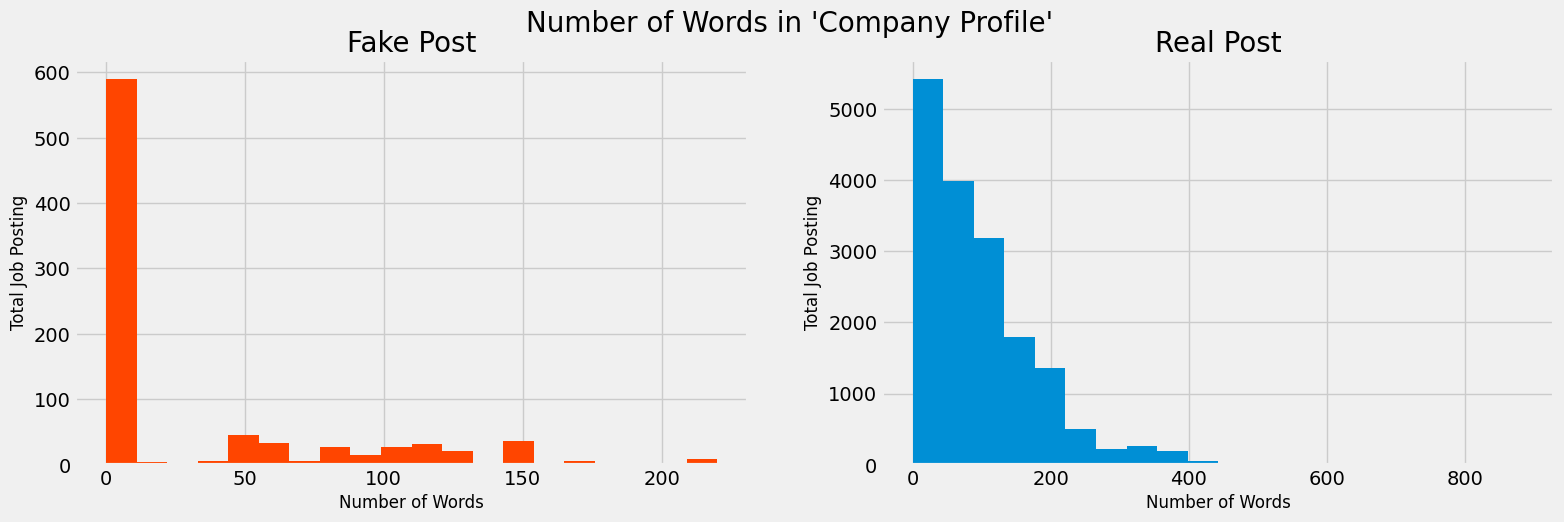

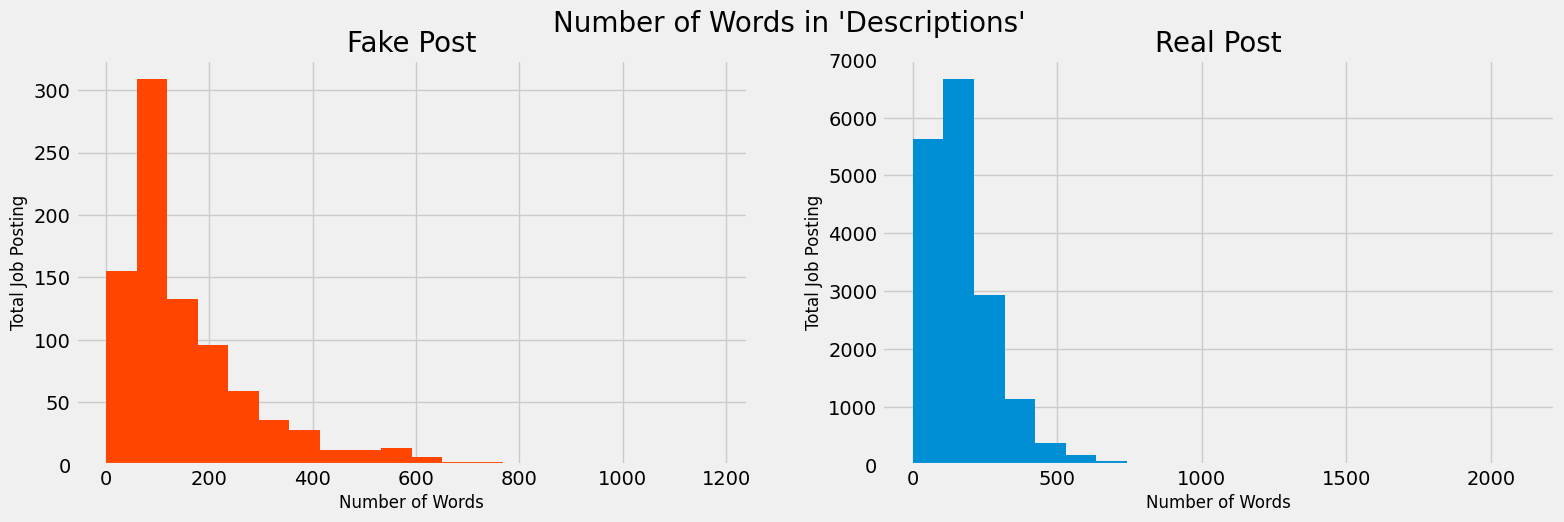

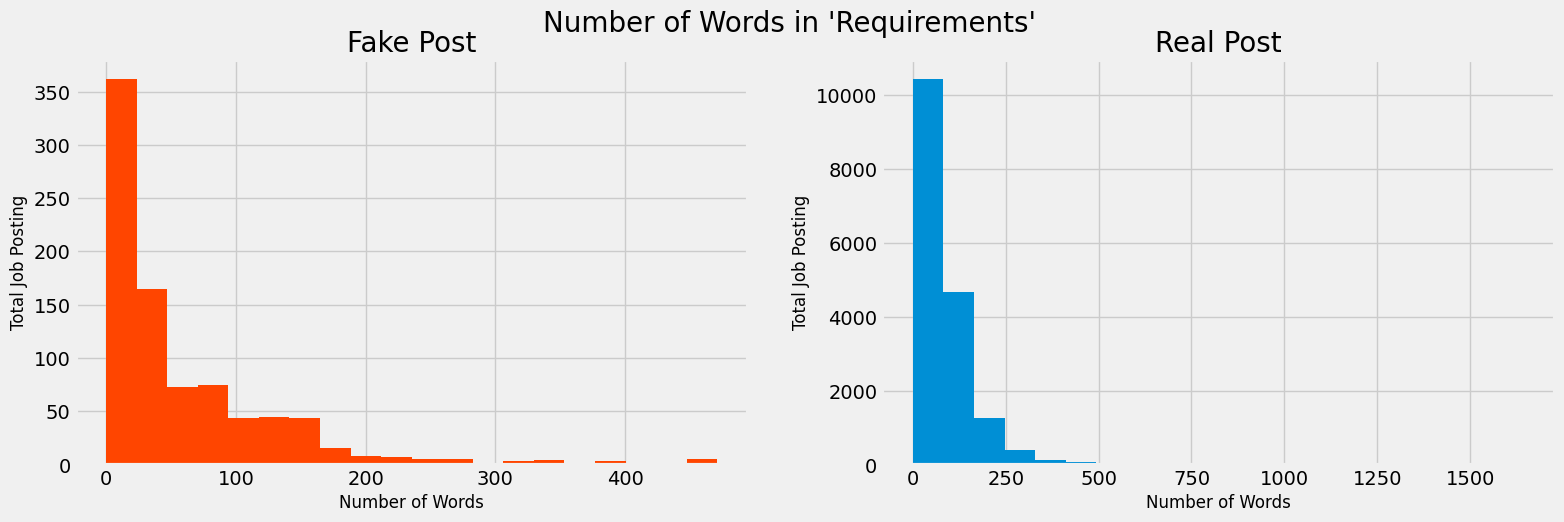

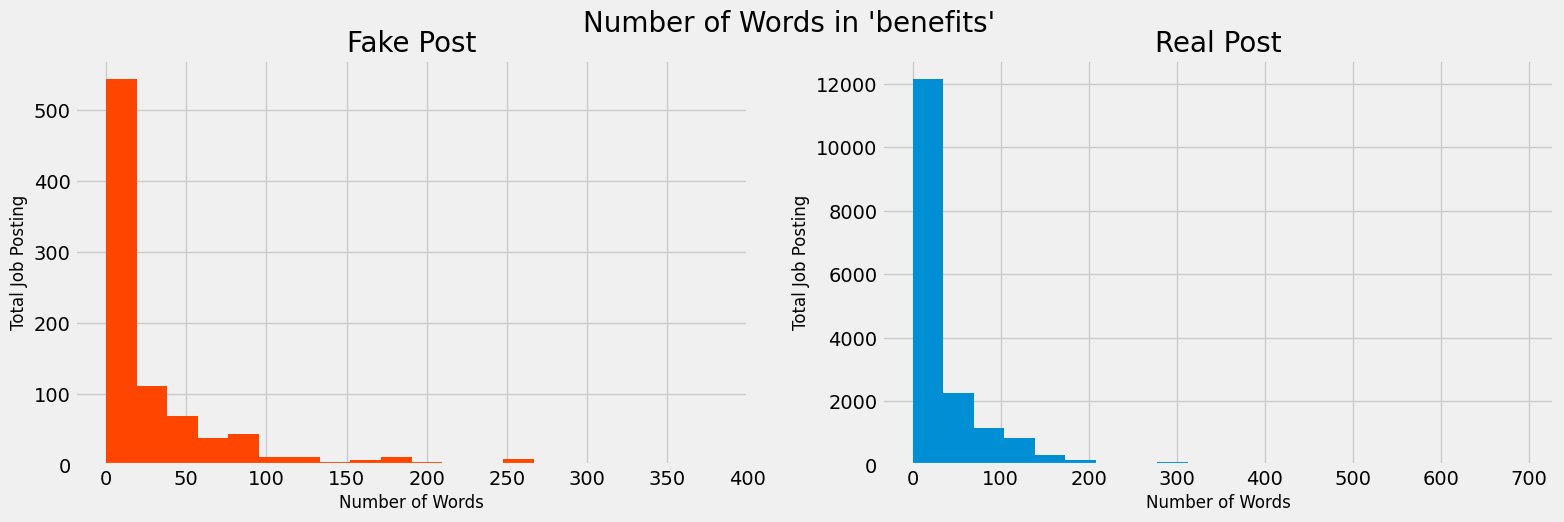

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
fig.suptitle("Number of Words in 'Company Profile'", fontsize = 20)

num = text_df[text_df["fraudulent"]==1]['company_profile'].str.split().map(lambda x: len(x))
ax1.hist(num, bins = 20, color = 'orangered')
ax1.set_title('Fake Post', fontsize=20)
ax1.set_xlabel('Number of Words', fontsize=12) # x axis label
ax1.set_ylabel('Total Job Posting', fontsize=12) # x axis label

num = text_df[text_df["fraudulent"]==0]['company_profile'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post', fontsize=20)
ax2.set_xlabel('Number of Words', fontsize=12) # x axis label
ax2.set_ylabel('Total Job Posting', fontsize=12) # x axis label

fig, (ax3, ax4) = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
fig.suptitle("Number of Words in 'Descriptions'", fontsize = 20)

num = text_df[text_df["fraudulent"]==1]['description'].str.split().map(lambda x: len(x))
ax3.hist(num, bins = 20, color = 'orangered')
ax3.set_title('Fake Post', fontsize=20)
ax3.set_xlabel('Number of Words', fontsize=12) # x axis label
ax3.set_ylabel('Total Job Posting', fontsize=12) # x axis label

num = text_df[text_df["fraudulent"]==0]['description'].str.split().map(lambda x: len(x))
ax4.hist(num, bins = 20)
ax4.set_title('Real Post', fontsize=20)
ax4.set_xlabel('Number of Words', fontsize=12) # x axis label
ax4.set_ylabel('Total Job Posting', fontsize=12) # x axis label

fig, (ax5, ax6) = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
fig.suptitle("Number of Words in 'Requirements'", fontsize = 20)

num = text_df[text_df["fraudulent"]==1]['requirements'].str.split().map(lambda x: len(x))
ax5.hist(num, bins = 20, color = 'orangered')
ax5.set_title('Fake Post', fontsize=20)
ax5.set_xlabel('Number of Words', fontsize=12) # x axis label
ax5.set_ylabel('Total Job Posting', fontsize=12) # x axis label

num = text_df[text_df["fraudulent"]==0]['requirements'].str.split().map(lambda x: len(x))
ax6.hist(num, bins = 20)
ax6.set_title('Real Post', fontsize=20)
ax6.set_xlabel('Number of Words', fontsize=12) # x axis label
ax6.set_ylabel('Total Job Posting', fontsize=12) # x axis label

fig, (ax7, ax8) = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
fig.suptitle("Number of Words in 'benefits'", fontsize = 20)

num = text_df[text_df["fraudulent"]==1]['benefits'].str.split().map(lambda x: len(x))
ax7.hist(num, bins = 20, color = 'orangered')
ax7.set_title('Fake Post', fontsize=20)
ax7.set_xlabel('Number of Words', fontsize=12) # x axis label
ax7.set_ylabel('Total Job Posting', fontsize=12) # x axis label

num = text_df[text_df["fraudulent"]==0]['benefits'].str.split().map(lambda x: len(x))
ax8.hist(num, bins = 20)
ax8.set_title('Real Post', fontsize=20)
ax8.set_xlabel('Number of Words', fontsize=12) # x axis label
ax8.set_ylabel('Total Job Posting', fontsize=12) # x axis label

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


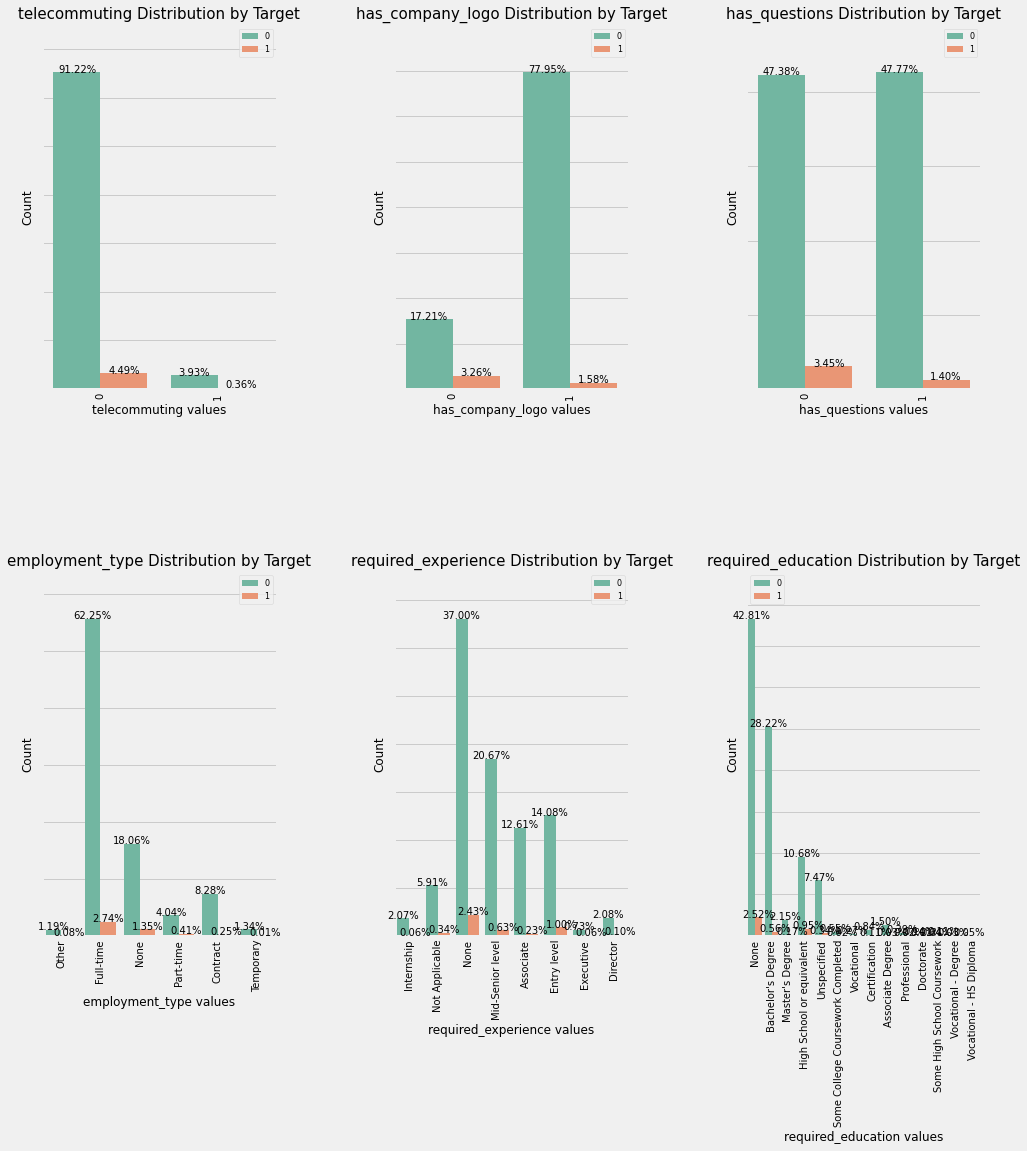

In [0]:
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education",]
# visualizating catagorical variable by target
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5) # The grid of chart
plt.figure(figsize=(15,25)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(cat_df[cat_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=cat_df, hue='fraudulent', palette='Set2') 
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=15) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels() 
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(fontsize=8)
    plt.xticks(rotation=90) 
    total = len(cat_df)
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights


plt.show()

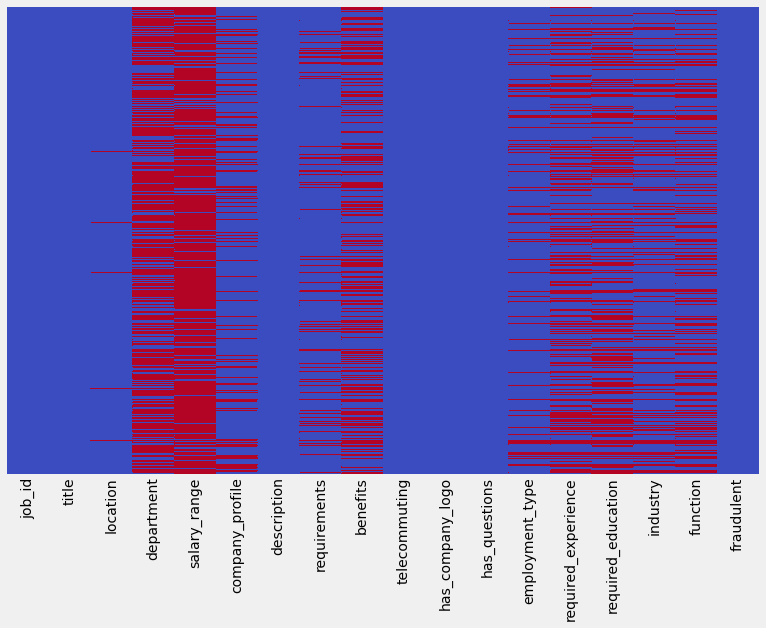

In [0]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cmap="coolwarm", yticklabels=False, cbar=False)

###**Identify Features & Label**

In [0]:
"""Concate the text data for preprocessing and modeling"""
#Define Feature & Labels
text_df = shuffle(text_df).reset_index(drop=True)

text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
#text = df['company_profile']
labels = df['fraudulent'] #<--Labels


print(len(text))
print(text.head())
print(len(labels))
print(labels.head())

17880
0    English Teacher Abroad ,We help teachers get s...
1    Principal Product Applications Engineer - MACs...
2    Customer Service Reps Needed For Expansion,LEI...
3    Java Developer,Located in the heart of downtow...
4    Graduates: English Teacher Abroad (Conversatio...
dtype: object
17880
0    0
1    0
2    0
3    0
4    0
Name: fraudulent, dtype: int64


###**Wordcloud & Ngrams Analysis**

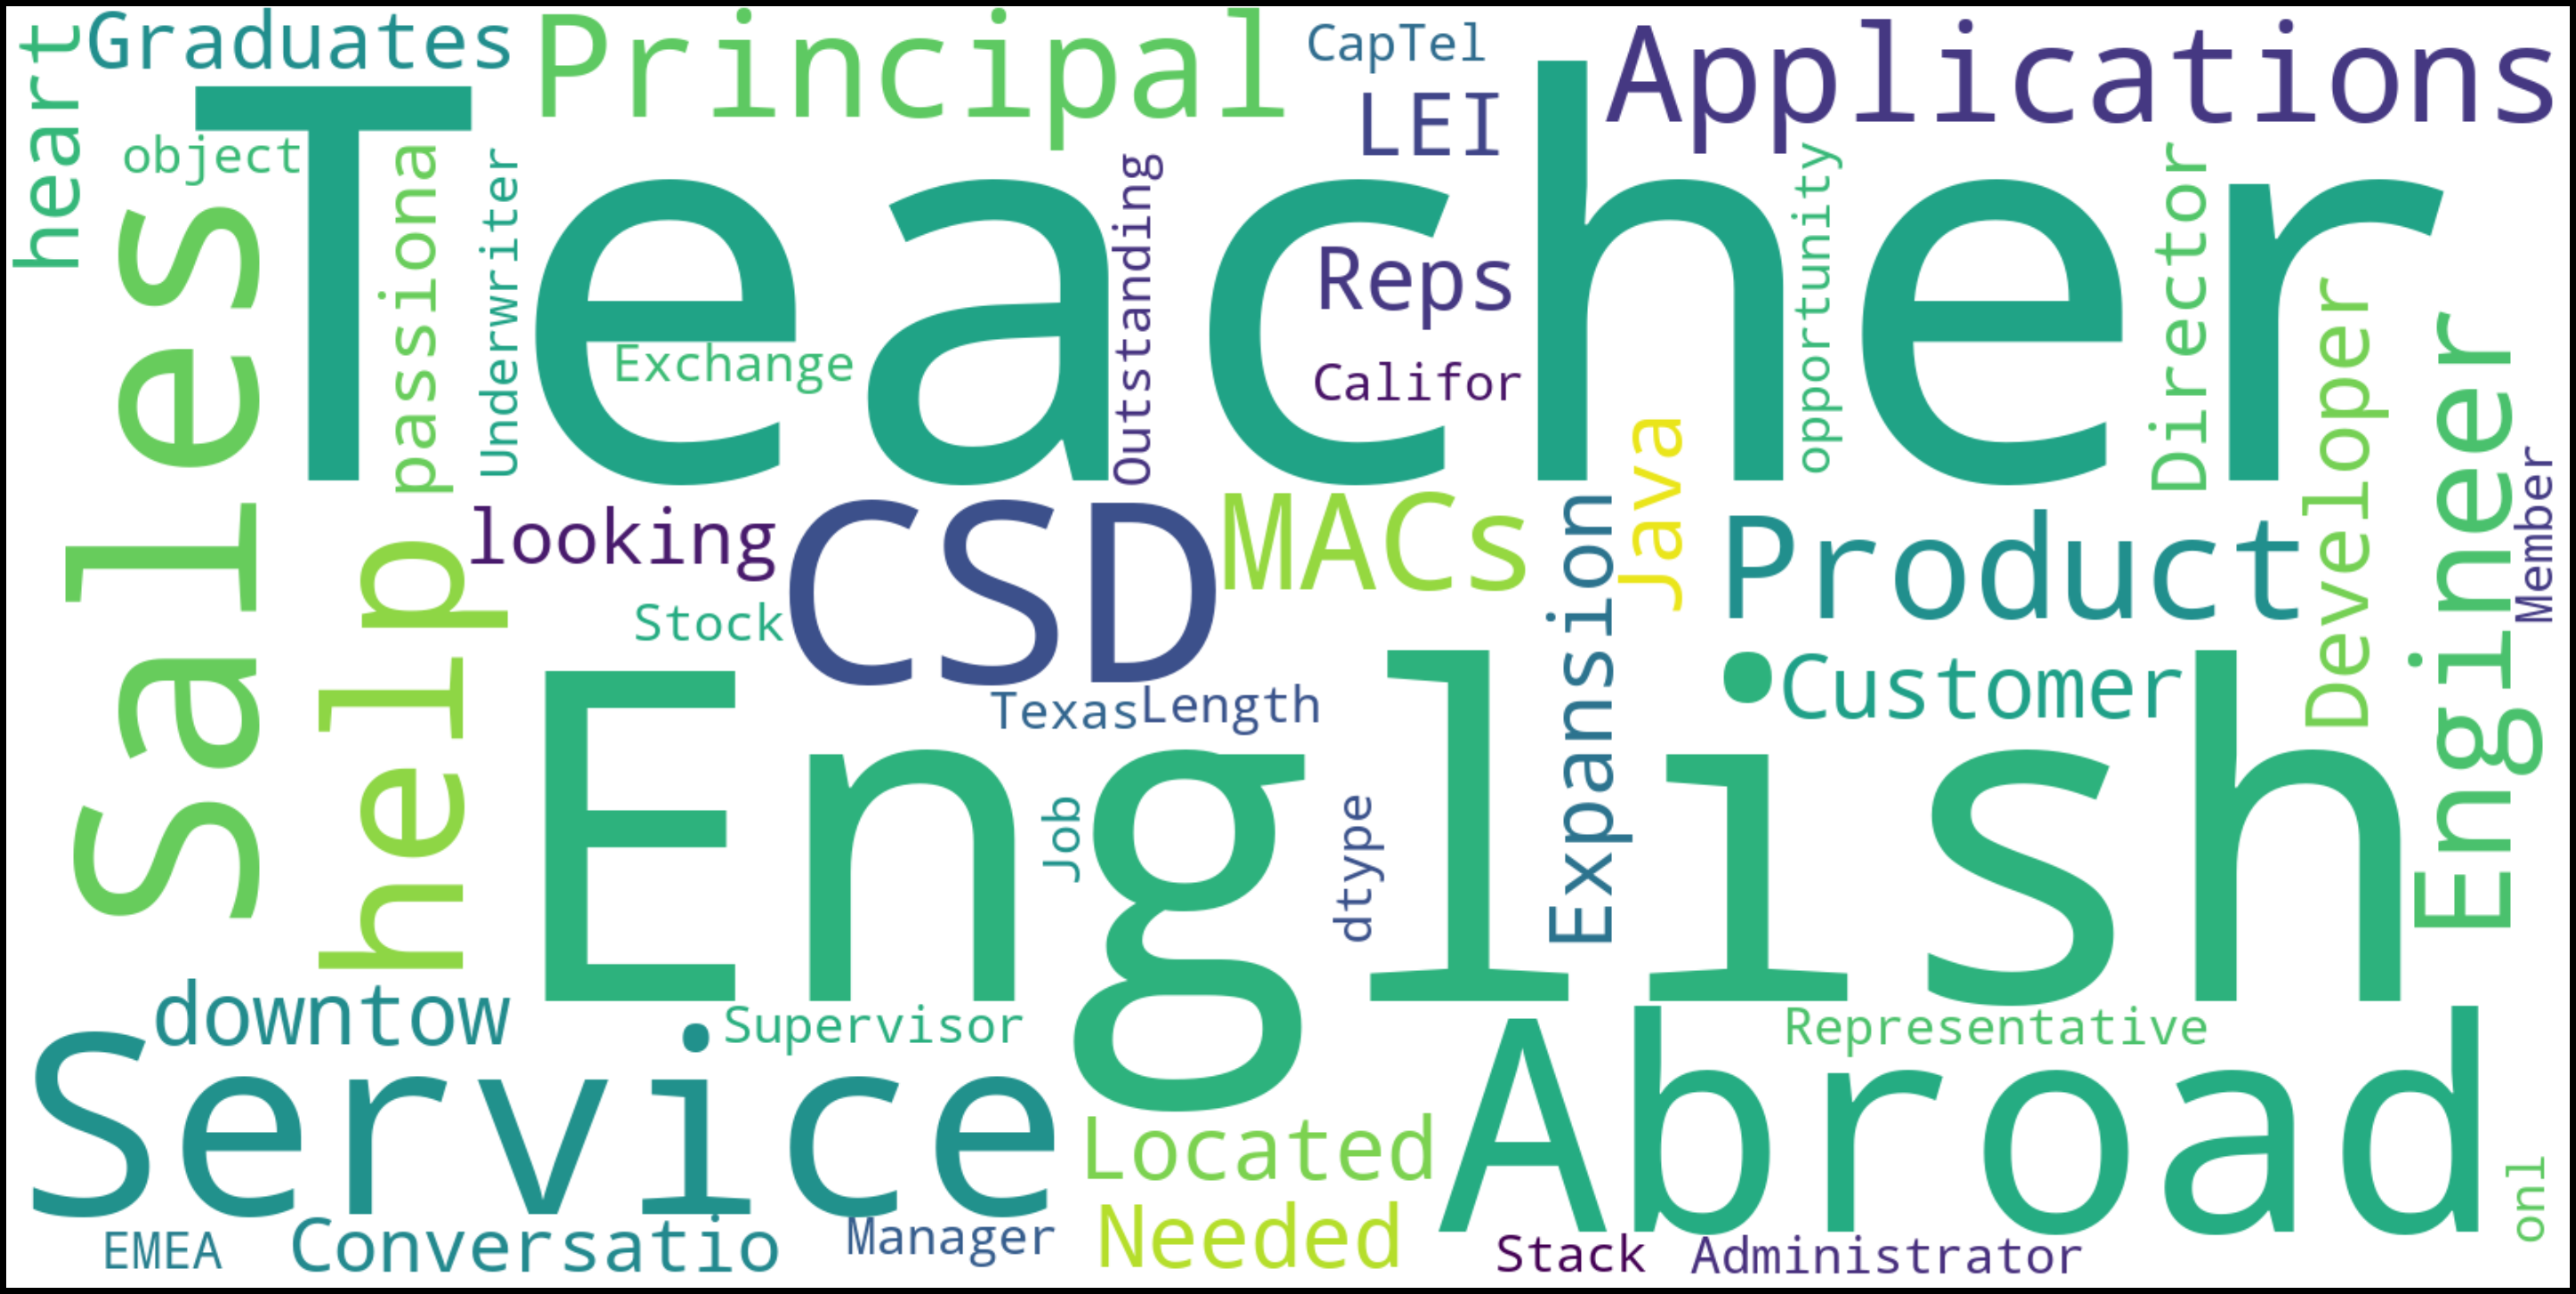

In [0]:
#Generating wordcloud that show most common word in News Title
#Counting Unique word to generate WordCloud
text_wc = text
wordcloud= WordCloud(
    width =1600,
    height = 800,
    background_color='white',
    stopwords=STOPWORDS).generate(str(text_wc))
fig = plt.figure(
    figsize = (40,30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

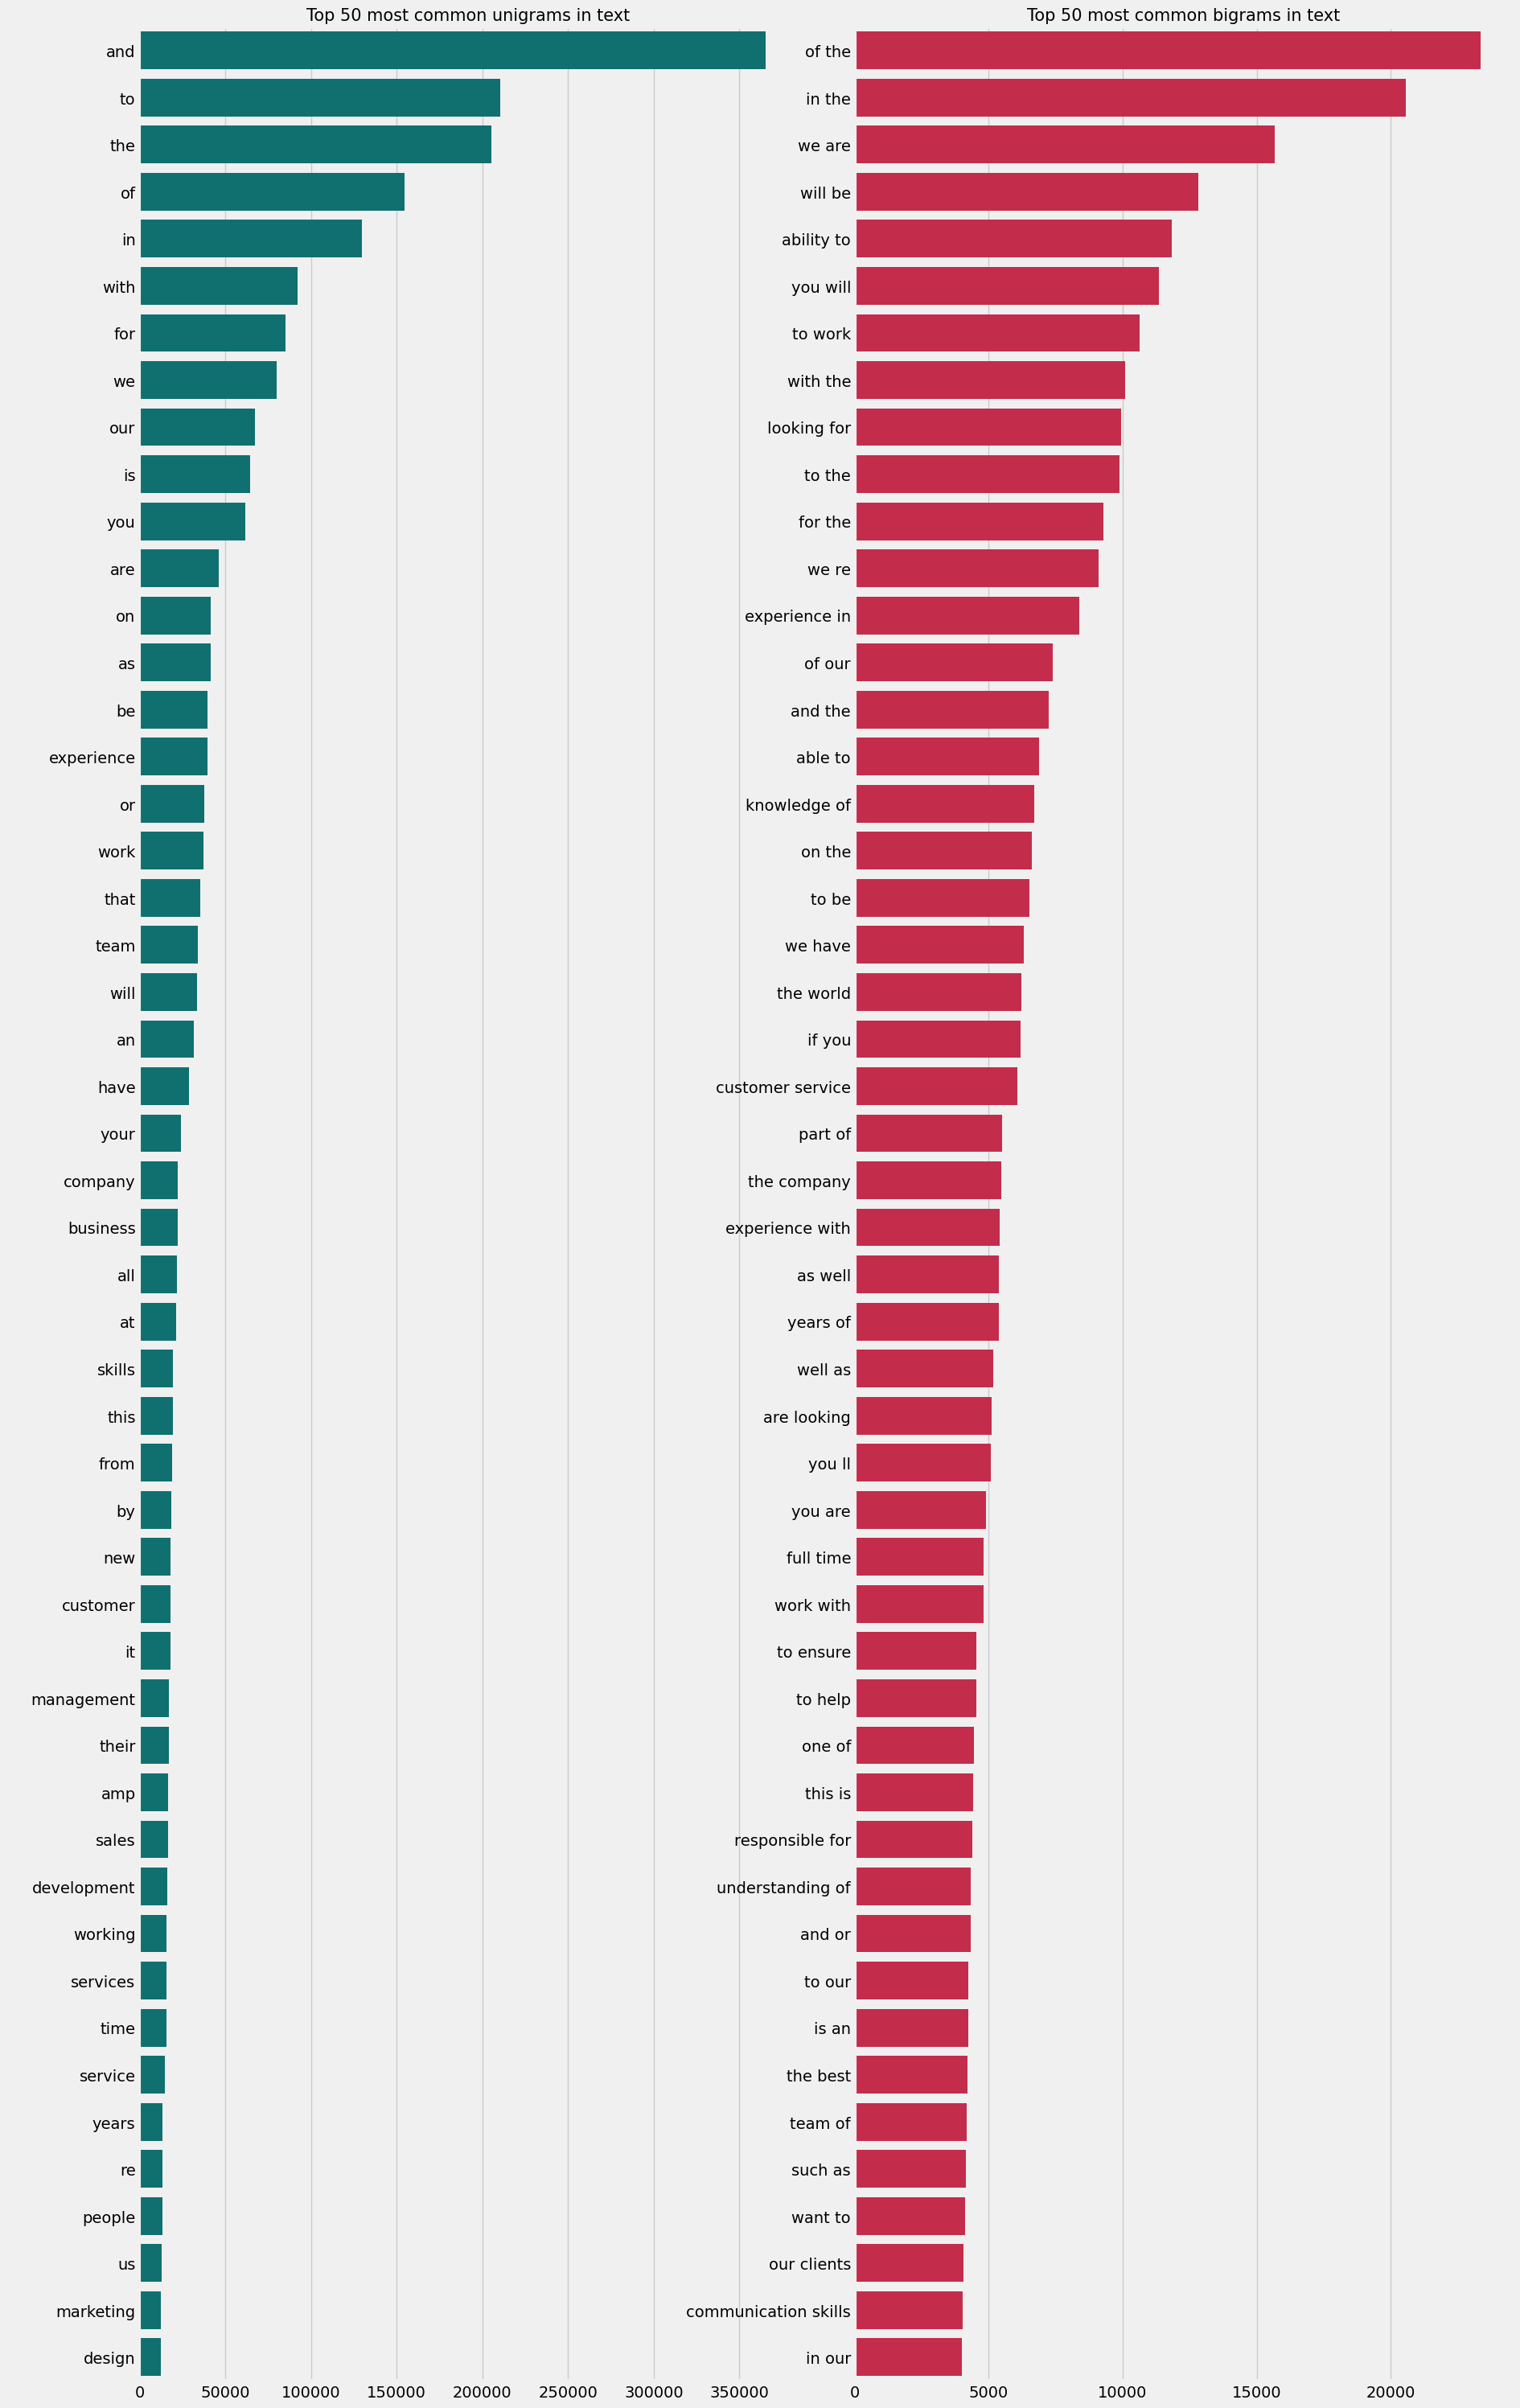

In [0]:
def get_top_tweet_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

top_unigrams=get_top_tweet_unigrams(text)[:50]
x,y=map(list,zip(*top_unigrams))
sns.barplot(x=y,y=x, ax=axes[0], color='teal')


top_bigrams=get_top_tweet_bigrams(text)[:50]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x, ax=axes[1], color='crimson')


axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Top 50 most common unigrams in text', fontsize=15)
axes[1].set_title('Top 50 most common bigrams in text', fontsize=15)

plt.show()


---
##**3. TRANSFORM DATASET**
  
  - Clean Text, Stopwords, and Lemmatizer 
  - Sampling & Splitting
  - Tokenizer, Sequence, Padded



###**Clean Text, Stopwords, and Lemmatizer**

In [0]:
#Load Stopwords, Stemmer, and Lemmatizer
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

swNot = ['no', 'nor', 'not', 'don', "don't", 'ain', 'aren', "aren't",
         'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't",
         'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
         "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
         "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
         "wasn't", 'weren', "weren't", "won't", 'wouldn',"wouldn't"]

for word in swNot:
   sw.remove(word)

print(sw)
#-------------------------------------------------------------------------------
#Define the replace_puncts, strip_chars, and puncts
#the list and arrays are going to be used in defining the functions
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']
#-------------------------------------------------------------------------------
#Define function that clean, lemmatize, process text, and remove stem words from text
#clena_text, which convert word to lower case and replace some characters
def clean_text(text):
    x = str(text)
    x = x.lower()
    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", text)
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
        
    for punct in strip_chars:
        x = x.replace(punct, ' ') 
    
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
   
    return text

#stopwords1, which remove the stopwords
def stopwords1(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

#lemm, which will lemmatize word
def lemm(text):    
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text) 

#text_processing, which incorporate all the function above into one function that will be used to process text later.
def text_processing(text):
    text=text.apply(stopwords1)
    text=text.apply(clean_text)
    text=text.apply(lemm)
    return text

clean_text = text_processing(text)
clean_text[2]


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', '

"customer service rep needed expansion,lei home enhancements, ohio based company installing windows, siding, door deck home throughout tri-state, dayton, indianapolis columbus seven years.with pride work, honesty integrity professionalism companywide dedication customer satisfaction, offer wide range remodeling service homeowners.whether project large small, understand trust confidence customer place skilled hands. that's use superior quality product exceptional craftsmanship achieve long-lasting beauty, performance value home. take every measure carefully ensure craftsman properly trained phase home improvement. likewise, sale staff customer service representative draw upon year experience quality installations.from day one, welcome question concern may renovation process. goal provide beautiful practical home improvement stand test time, along peace mind made excellent selection home.,customer service rep needed expansion rapidly growing company looking 4-8 professional join teamresp

###**Sampling & Splitting**

In [0]:
x_train, x_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42)

print(len(x_train))
print(len(y_train))
print(x_train.head())
print(y_train.head())
print(len(x_test))
print(len(y_test))
print(x_test.head())
print(y_test.head())

14304
14304
2112     Marketing Operations Supervisor,At Hayes-Corp,...
7571     Project Manager,A Creative agency for Web Desi...
764      FRONT END DEVELOPER NYC,LOOP is an award winni...
17291    Title Closer,Network Closing Services has been...
16069    UX Architect & Designer,Founded in 2010 by a t...
dtype: object
2112     0
7571     0
764      0
17291    0
16069    0
Name: fraudulent, dtype: int64
3576
3576
4708     Paid Training for Direct Sales Representative ...
11079    Collections Supervisor,Tidewater Finance Co. w...
12357    Beauty & Fragrance consultants needed,Establis...
14511    iOS Engineer,AGOGO creates a personalized audi...
16691    Front End Developer,Entertainment everywhere. ...
dtype: object
4708     0
11079    0
12357    0
14511    0
16691    0
Name: fraudulent, dtype: int64


In [0]:
train_size = int(len(x_train)*0.8)
x_trainset = x_train[:train_size]
y_trainset = y_train[:train_size]

x_valset = x_train[train_size:]
y_valset = y_train[train_size:]

print(train_size)
print(len(x_trainset))
print(len(y_trainset))
print(len(x_valset))
print(len(y_valset))

11443
11443
11443
2861
2861


###**Tokenizer, Sequence, Padded**

In [0]:
#Set Hyperparameters
vocab_size = 60000 #Tweak this parameter
embedding_dim = 32
max_length = 500
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


In [0]:
#Tokenizer, Sequence, Padded for Training Dataset
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_trainset)
word_index = tokenizer.word_index
print(len(word_index))
#print(word_index)

train_sequences = tokenizer.texts_to_sequences(x_trainset)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))
print(train_padded[0])
print(len(train_sequences[1]))
print(len(train_padded[1]))
print(train_padded[1])
print(len(train_sequences[10]))
print(len(train_padded[10]))
print(train_padded[10])


102515
248
500
[   49   254  1043    30  4958  3542    11   178     4   356  1749    26
     8     6   304    16    63    42     9   120   686    11    14  1134
    53     9   317    48    23    62   507   581     4  1558  5794     2
  2110    26   958    13  1024   971    15     6  4634     6  3234    19
     6   563  7106    11   673    13     4   395     3   425    30   124
    13   103    94  1408    13  1006   414     6    88    13   117    83
   507    13    25   124    46   997   250   904    27   612  3836   236
  7210    13    22    77   179   119    95    42     2   475     4   894
 31638   125   136    83    14    66   614     3   897   618     2   130
   123   985    42 19661   119    49   998     9   343   120   123   987
     2 46005     3    20     8   482  1009    75    46     2    28 46006
     8   470     7   444  3974     2   179  5304  5610   216     3   121
   651     2   879 46007   130   123   985    42     2    39     2    67
  3543    15 46008    92  1826     7

In [0]:
validation_sequences = tokenizer.texts_to_sequences(x_valset)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

2861
(2861, 500)


---
##**4. BUILD AND TRAIN MODEL**
  - Neural Network Architecture
  - Train Model
  - Evaluate Model Accuracy

In [0]:
#def build_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional((LSTM(64, return_sequences = True, recurrent_dropout=0.5))),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
  model.summary()
  #return model
#print("Defined the build_model")

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 500, 32)           1920000   
_________________________________________________________________
dropout_24 (Dropout)         (None, 500, 32)           0         
_________________________________________________________________
global_average_pooling1d_12  (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 12)                396       
_________________________________________________________________
dropout_25 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 13        
Total params: 1,920,409
Trainable params: 1,920,409
Non-trainable params: 0
___________________________________________

In [0]:

batch_size = 10
#def train_model(model, train_padded, y_trainset, num_epochs):
history = model.fit(train_padded, 
                      y_trainset, 
                      #batch_size = batch_size,
                      epochs=num_epochs, 
                      validation_data=(validation_padded, y_valset), 
                      verbose=2)
#return history.epoch, history.history['acc'][-1]
print("Defined the train_model")

Epoch 1/10
358/358 - 9s - loss: 0.3058 - accuracy: 0.9516 - val_loss: 0.1995 - val_accuracy: 0.9493
Epoch 2/10
358/358 - 9s - loss: 0.1997 - accuracy: 0.9528 - val_loss: 0.1995 - val_accuracy: 0.9493
Epoch 3/10
358/358 - 9s - loss: 0.1987 - accuracy: 0.9528 - val_loss: 0.2005 - val_accuracy: 0.9493
Epoch 4/10
358/358 - 8s - loss: 0.1949 - accuracy: 0.9528 - val_loss: 0.2021 - val_accuracy: 0.9493
Epoch 5/10
358/358 - 8s - loss: 0.1932 - accuracy: 0.9528 - val_loss: 0.2013 - val_accuracy: 0.9493
Epoch 6/10
358/358 - 9s - loss: 0.1922 - accuracy: 0.9528 - val_loss: 0.2028 - val_accuracy: 0.9493
Epoch 7/10
358/358 - 9s - loss: 0.1875 - accuracy: 0.9528 - val_loss: 0.2024 - val_accuracy: 0.9493
Epoch 8/10
358/358 - 9s - loss: 0.1821 - accuracy: 0.9528 - val_loss: 0.2053 - val_accuracy: 0.9493
Epoch 9/10
358/358 - 9s - loss: 0.1758 - accuracy: 0.9528 - val_loss: 0.2061 - val_accuracy: 0.9493
Epoch 10/10
358/358 - 9s - loss: 0.1672 - accuracy: 0.9528 - val_loss: 0.2122 - val_accuracy: 0.9493

In [0]:
model.evaluate(test_padded, y_test)

112/112 [==============================] - 0s 2ms/step - loss: 0.2111 - accuracy: 0.9494


[0.21114102005958557, 0.9493848085403442]

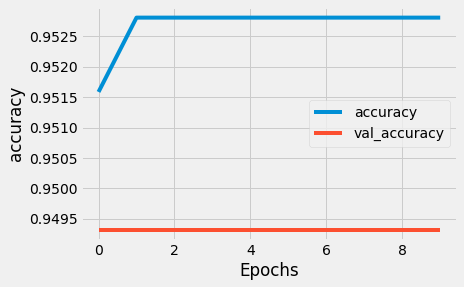

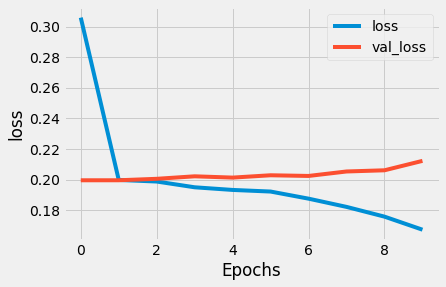

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) #Shape: (vocab_size, embedding_dim)


(60000, 32)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try: 
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

---
##**5. RESULT & CONCLUSION**

1. Training & Testing Result
  - During training, the training loss slightly decrease, while the validation loss slowly increase.
  - During training, the training accuracy higher than the validation accuracy with stable graph.
  - Testing result is closly similar with validation result.
2. Accuracy Training & Testing Result
  - Training Accuracy : 95.2%
  - Validation Accuracy : 94.9%
  - Testing Accuracy : 94.9%

3. Loss Training & Testing Result
  - Training Loss : 0.1672
  - Validation Loss : 0.2122
  - Testing Loss : 0.2111